[Back to Table of Contents](https://www.shannonmburns.com/Psyc158/intro.html)

[Previous: Chapter 18 - Evaluating Effect Sizes](https://colab.research.google.com/github/smburns47/Psyc158/blob/main/chapter-18.ipynb)

In [ ]:
# Run this first so it's ready by the time you need it
install.packages("dplyr")
install.packages("ggformula")
install.packages("performance")
install.packages("see")
install.packages("patchwork")
library(dplyr)
library(ggformula)
library(performance)

# Chapter 19 - Model Bias

## 19.1 Error vs. bias

We use statistics to try and explain complex things in the world, and arrive at some general conclusions about what we can expect. More specifically in the context of the general linear model, we try to model the data generation process of data we care about and see what information helps us make the best predictions about those data.

We know from our discussion of model error that it is hard and maybe impossible to make perfectly correct predictions. In any data generation process, we might be able to figure out that using information from some predictor variables helps us explain some variation in an outcome variable and make *better* predictions, but there is almost always some error left unexplained.  

<img src="images/ch10-var1.png" width="500">

For any particular prediction we make about the outcome value of one data point, that prediction is likely to be off by a bit. This amount that we typically miss by is the error of a model. We can quantify it by looking at the distribution of the residuals a model produces when making predictions. For example, let's simulate a sample of data with a partially-known data generation process, and make predictions using the part of the model that we know: 

In [240]:
x <- rnorm(100,0,1)  #defining a random variable
e <- rnorm(100,0,1)  #some unexplained error
y <- 2 + 0.5*x + e   #the data generation process 

predicted_y <- 2 + 0.5*x
residuals <- y - predicted_y

If we plot the residuals of the model in this sample, making a histogram of the error distribution, we see that most of them are non-zero. We are missing our predictions by a bit. 

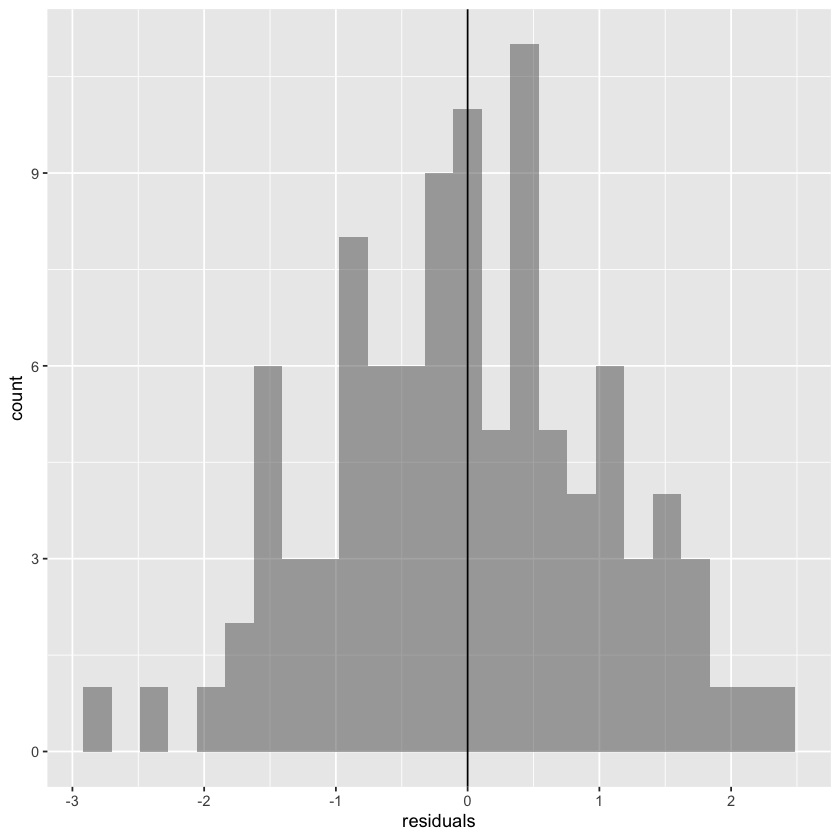

In [241]:
gf_histogram(~ residuals)%>% gf_vline(., xintercept = 0)

The spread of the error distribution tells us by how much we typically miss our predictions. A wide error distribution means a model has a lot of error. The narrower we can make the error distribution, and the less error there is, the better our model. 

However, model error isn't the only thing for us to be aware of when relying on the predictions a model makes. Let's imagine a situation where the true data generation process only has a very small amount of unaccountable variation, so that we are able to explain almost all the error. We can still make very inaccurate predictions if we use the wrong coefficients in a model: 

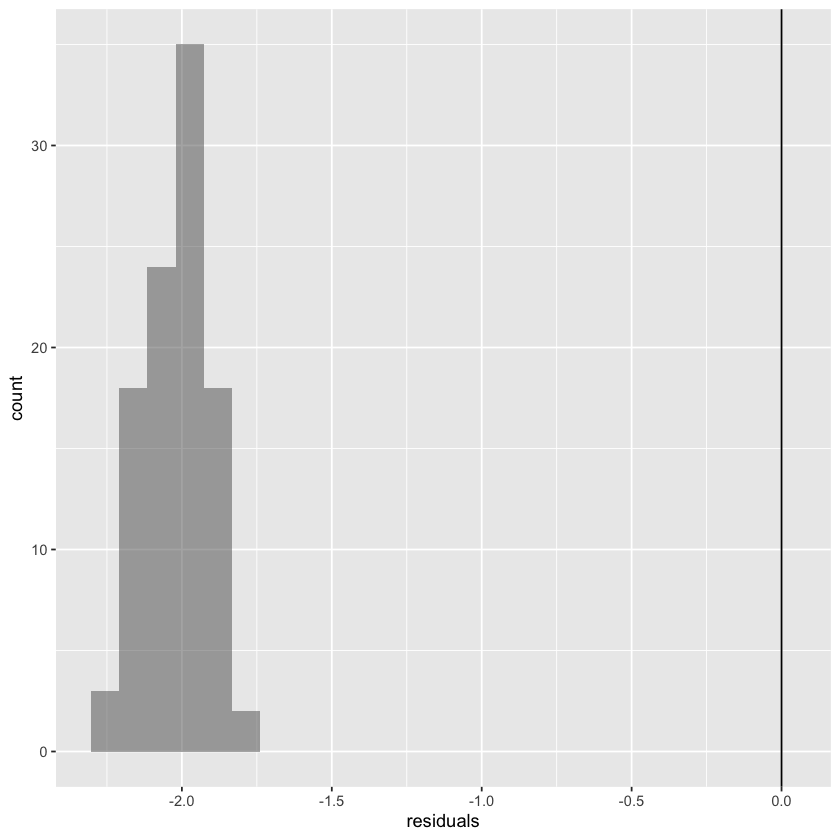

In [239]:
x <- rnorm(100,0,1)     #defining a random variable
e <- rnorm(100,0,0.1)   #tiny unexplained error
y <- 2 + 0.5*x + e      #data generation process
sim_df <- data.frame(x,y)

biased_y <- 4 + 0.5*x
residuals <- y - biased_y

gf_histogram(~ residuals)%>% gf_vline(., xintercept = 0)

Take a look at the center of both these error distributions. In the first error distribution we made, few residual values were exactly equal to 0 (few predictions were perfect), but across all the residuals they clustered *around* 0. That means even if any one prediction is unlikely to be perfect, the predictions as a whole aren't missing in any systematic way. 

In contrast, the spread of the second error distribution is narrow, but the central tendency is way off 0. This means that every prediction we are making is wrong, and they're all wrong in the same way. 

This is known as **bias**. A model has error if its predictions are sometimes wrong. A model has bias if the predictions are wrong in a systematic way. 

We can use a bulls-eye metaphor to understand predictions in terms of error and bias. If the bulls-eye is the actual value of a datapoint on an outcome variable and each dot is a prediction, model error refers to the spread of those predictions while model bias refers to where those predictions are centered on. 

<img src="images/ch20-errorbias.png" width="500">

What will make a model biased? Take a look at the model coefficients that were used to make predictions for both error distributions above. In the unbiased model, we used the values "2" and "0.5" as coefficients for the ```intercept``` and ```x```, respectively, in order to make predictions about ```y```. These are the exact same values we used in the data generation process for y, so we know the only reason our predictions were off is because we didn't know the value of ```e``` to include in the prediction equation. 

In the biased model, we used "4" instead of "2" for the coefficient of the intercept. This made our predictions systematically overshoot the actual values of ```y```. 

While error speaks to the spread of the error distribution, bias is about the central tendency. If the central tendency of the the error distribution is not zero, a model is biased.

## 19.2 Out-of-sample predictions

In practice, if you fit models in R, the model will never be biased *for this data sample*. This is because R automatically computes the best-fitting coefficients to reduce error and eliminate bias (this is what using the mean as a model does inherently). However, usually we care about more than just these data. A bigger concern is thus whether the model will be biased *for new data*.

Recall from our discussion of sampling distributions that any one estimate derived from a data sample is unlikely to exactly match the population parameter. For example, let's simulate an entire population of data with the same data generation process above, and fit a model in just a sample of it: 

In [242]:
set.seed(30)
x <- rnorm(10000,0,1)  #defining a random variable
e <- rnorm(10000,0,1)  #some unexplained error
y <- 2 + 0.5*x + e     #data generation process 
sim_df <- data.frame(x,y)

sim_sample <- slice_sample(sim_df, n=100, replace=TRUE)

sim_model <- lm(y ~ x, data = sim_sample)
sim_model


Call:
lm(formula = y ~ x, data = sim_sample)

Coefficients:
(Intercept)            x  
     1.9539       0.5747  


Whereas the true intercept and effect of x are 2 and 0.5 respectively, our estimates for those coefficients are 1.95 and 0.57. If we were to use these values to make predictions within a separate dataset:

In [243]:
set.seed(40)
sim_sample2 <- slice_sample(sim_df, n=100, replace=TRUE)

predicted_y <- predict(sim_model, sim_sample2)
residuals <- sim_sample2$y - predicted_y
mean(residuals) #center of the error distribution

[1] 0.1169472

The residuals are not centered on 0. This is because the model coefficients we used for predictions are just estimates of the population parameter and in this case didn't exactly match. Making predictions about new data will thus be wrong in a systemic way. 

There are a few things we can do to minimize bias when making out-of-sample predictions. One of them is to collect larger samples:

In [244]:
set.seed(50)
sim_sample <- slice_sample(sim_df, n=1000, replace=TRUE) #bigger sample
sim_model <- lm(y ~ x, data = sim_sample)


sim_sample2 <- slice_sample(sim_df, n=1000, replace=TRUE) #bigger sample

predicted_y <- predict(sim_model, newdata = sim_sample2)
residuals <- sim_sample2$y - predicted_y
mean(residuals) #center of the error distribution


[1] -0.01716758

The center of the error distribution when we make predictions in ```sim_sample2``` using the model fitted on ```sim_sample1``` is still not 0, but it's much closer to 0. This is because of the Central Limit Theorem - with bigger samples, there is less variance in coefficient estimates sample to sample. 

Another option is to collect several small samples and then average together their effect:

In [245]:
#drawing many samples and saving their coefficients
b0s <- vector(length=100)
b1s <- vector(length=100)
for (i in 1:100) {
    sim_sample <- slice_sample(sim_df, n=100, replace=TRUE) 
    sim_model <- lm(y ~ x, data = sim_sample)
    b0s[i] <- sim_model$coefficients[[1]]
    b1s[i] <- sim_model$coefficients[[2]]
}

mean_b0 <- mean(b0s)
mean_b1 <- mean(b1s)

#predicting new data in the population based on average estimated effect
predicted_y <- mean_b0 + mean_b1*sim_df$x
residuals <- sim_df$y - predicted_y
mean(residuals) #center of the error distribution

[1] -0.009816172

This is what people are doing when they perform a meta-analysis. They are compiling the estimates across many different studies to arrive at one average effect that is hopefully closer to the true population parameter, and thus produces less bias in new predictions. 

### Biased and unbiased estimates

In the example above, we saw that even if coefficient estimates derived in one sample are different from the true population parameter and produced biased out-of-sample predictions by themselves, *on average* across many studies these estimates converged on the population parameter. This means that if we repeat our sampling and analysis process many times (or if we get a really big sample size), there is no systematic bias in our estimation of the population parameter. This is the difference between bias in predictions and bias in estimates. Over many data points there may be error in residuals but no bias in predictions. Comparably, over many studies there may be error in effect estimations but no bias in the estimated population parameter.

It is possible to get bias in coefficient estimations, however. This is the worst situation for bias because if your effect estimate is always off, your predictions will always be off too in a systematic way and no amount of sample size or meta-analyzing will help you. 

## 19.3 Sources of bias 

Typically, the GLM framework produces unbiased estimates. This is why it is a popular framework for doing statistical analysis. But this only holds if your data meets certain assumptions that the GLM has about it, or if your data are a good sample of the population. The GLM framework is really powerful, but it's not infallible. There are situations where it is not the appropriate statistical method to use. For the rest of the chapter we will learn about sources of bias in the data that can make the GLM systematically perform poorly. We will also learn what to do if you find these sources of bias in your data. 

Luckily, for several of these sources of bias, we can evaluate if they are present in our data. This enables us to make informed decisions about our modeling procedure. 

### 1) Nonlinearity

Throughout this course we've been learning how to use the General *Linear* Model for prediction and inference. A "linear" model means that the best fitting regression line through the scatterplot of X/Y association is straight. This is specified during the fitting process by combining predictors with addition. Another way of looking at it is that the slope of the effect of X is the same regardless of the value of X.

<img src="images/ch14-linear.png" width="250">

However another data situation is when the effect of X *changes* depending on the value of X. In this case, the best-fitting regression line through the data is not straight. 

<img src="images/ch14-nonlinear.png" width="250">

The GLM form that we've been using assumes that the linear type of relationship is what best fits the data. Much of the time it is safe to assume that the relationship between a predictor and an outcome is linear. However if you happen to be dealing with a nonlinear situation and you misspecify the model as linear by using the basic form of the GLM, this can result in bias. 

We can use simulation to see how this bias would play out. First, we will simulate a relationship between x and y where the true $\beta_1$ is 0.5, but in a log relationship such that as x gets larger, its effect on y gets smaller. You can see such a relationship in the scatterplot below, where the red line is the curved log relationship between x and y:

`geom_smooth()` using method = 'loess'


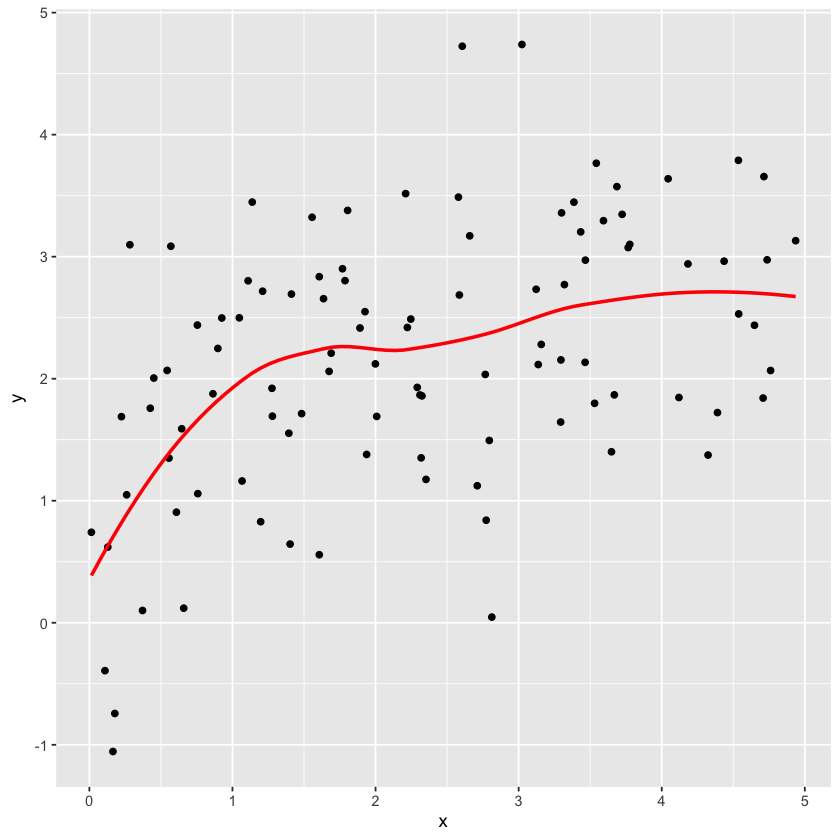

In [247]:
set.seed(10)
x <- runif(10000,0,5)    #defining a random variable
e <- rnorm(10000,0,1)    #some unexplained error
x_log <- log(x)
y <- 2 + 0.5*x_log + e  #0.5 is the true b1 value in a log model 
sim_df <- data.frame(x, x_log, y)

sim_sample <- sample_n(sim_df, size=100, replace=TRUE)

#scatterplot of true data generation process with incorrect linear predictions
gf_point(y ~ x, data = sim_sample) %>% gf_smooth(color='red')

Now let's draw many such samples from this data generation process to see the sampling distribution of the $b_1$ estimates:

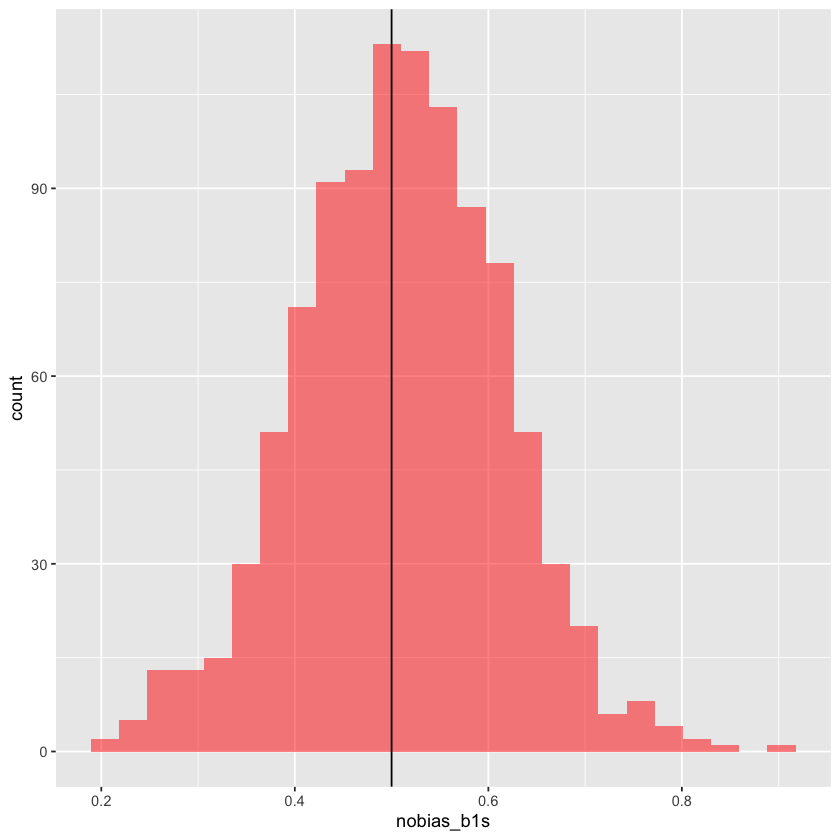

In [248]:
#sampling many estimates of unbiased b1
nobias_b1s <- vector(length=1000)
for (i in 1:1000) {
    sim_sample <- sample_n(sim_df, size=100, replace=TRUE) 
    sim_model <- lm(y ~ x_log, data = sim_sample)  
    nobias_b1s[i] <- sim_model$coefficients[[2]]
}

#red = unbiased sampling distribution
gf_histogram(~ nobias_b1s, fill="red", alpha=0.5) %>% 
    gf_vline(., xintercept = 0.5) #true b1 is 0.5

As we can see from these results, any one sample may find a $b_1$ estimate that is larger or smaller than the true effect 0.5, but in general they will cluster around 0.5.

Now let's try a simulation of what happens when the true data generation process is nonlinear like this, but we try to make predictions with a linear model. 

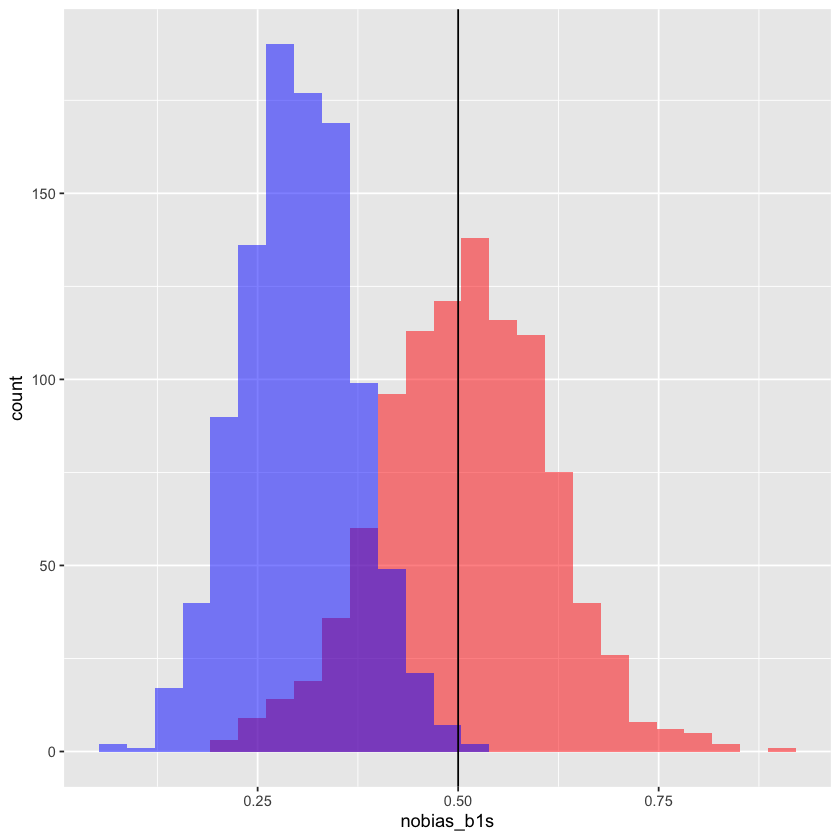

In [249]:
#sampling many estimates of biased b1
bias_b1s <- vector(length=1000)

for (i in 1:1000) {
    sim_sample <- sample_n(sim_df, size=100, replace=TRUE) 
    sim_model <- lm(y ~ x, data = sim_sample)  #fitting a linear model instead of nonlinear
    bias_b1s[i] <- sim_model$coefficients[[2]]
}

#red = unbiased sampling distribution
#blue = biased sampling distribution
gf_histogram(~ nobias_b1s, fill="red", alpha=0.5) %>% 
    gf_histogram(~ bias_b1s, fill="blue", alpha=0.5) %>%
    gf_vline(., xintercept = 0.5) #true b1 is 0.5

This model misspecification causes the sampling distribution of $b_1$ estimates to center on ~0.3 rather than 0.5 as in the true data generation process. By misspecifying the model, we are systematically wrong on the estimation of $\beta_1$ and thus making consistently wrong guesses about the effect of x on y. If we were to take a model estimate at face value without investigating whether the data should actually be fit with a linear model, we'd make incorrect conclusions about the true effect size. This is an example of model bias.  

### 2) Heteroscedasticity

The second assumption of the GLM is that there is constant residual variance at each value of model prediction. The best way to understand this is visually. We will make a plot where, as a predictor x increases, the error in the model increases as well: 

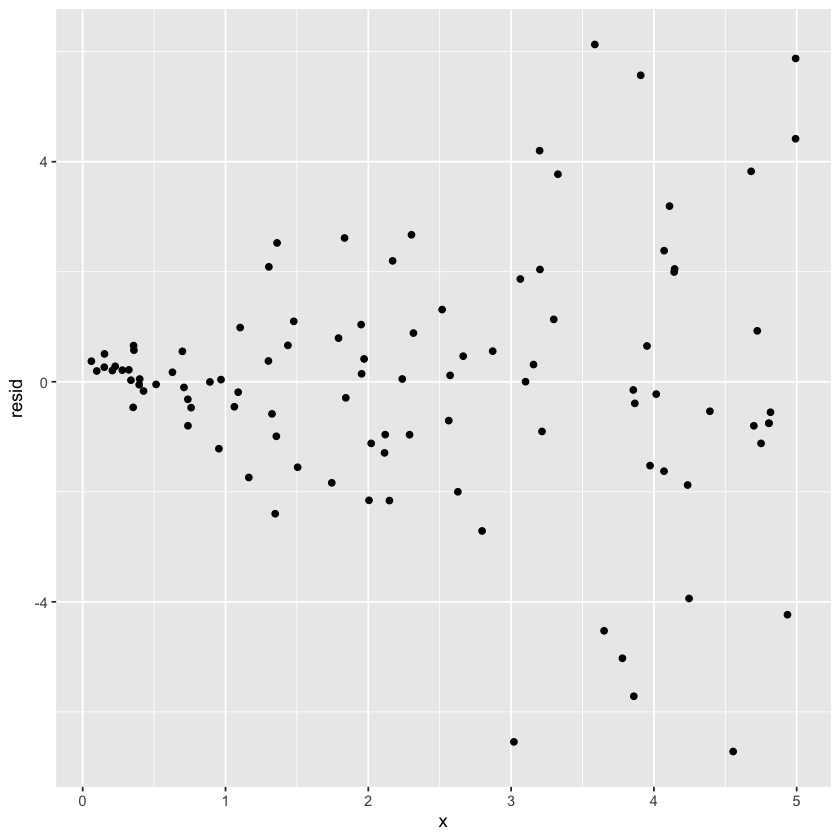

In [270]:
x <- runif(10000,0,5)             #defining a random variable
e_het <- x*rnorm(10000,0,1)    #error gets wider as a function of predictor
e_hom <- rnorm(10000,0,1)
y_het <- 0.5*x + e_het
y_hom <- 0.5*x + e_hom
sim_df <- data.frame(x, y_het, y_hom)

subsample <- sample_n(sim_df, size=100, replace=TRUE)
sub_model <- lm(y_het ~ x, data = subsample)
subsample$resid <- subsample$y_het - predict(sub_model, subsample)
gf_point(resid ~ x, data=subsample)

In this plot we are showing model residuals as they vary with a predictor x. When the assumption of homogeneity of variance is met, this plot should look like a fairly consistent cloud where the range of residuals is about the same for every value the model predicts. If there is instead a clear cone shape like in this plot, this means the error around the model prediction changes depending on what is being predicted, and the assumption is violated. Other words you might hear that refer to this assumption is **homoscedasticity** (when residual variance is homogenous) and **heteroscedasticity** (when residual variance is not constant).

This situation will occur if measurement error is correlated with values of the predictor. Let's run another simulation and see what happens when this assumption is violated:

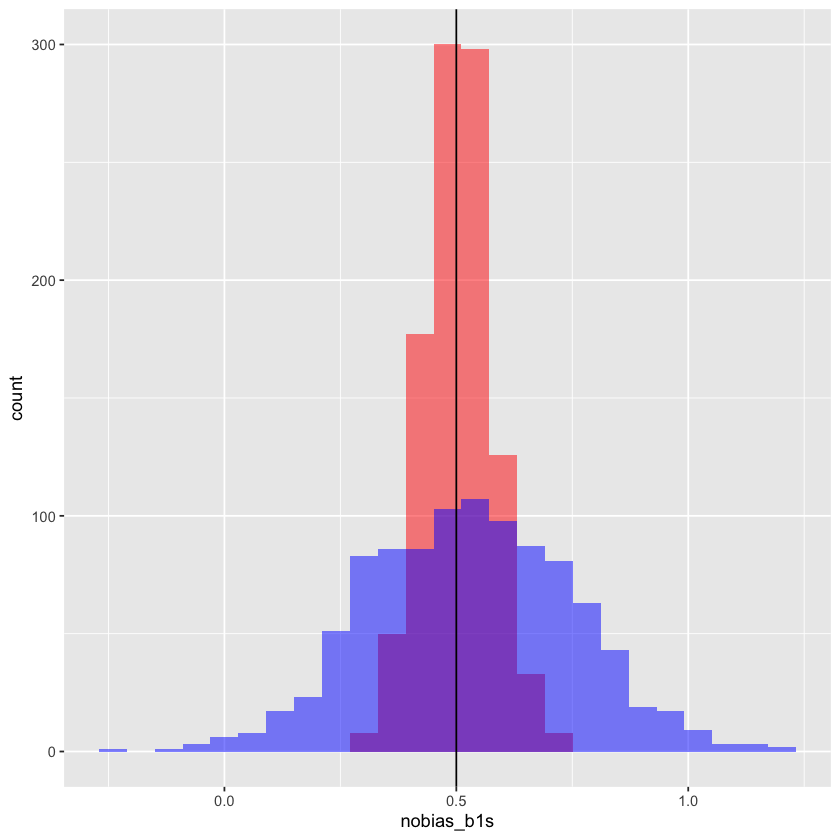

In [271]:
#sampling distribution of b1 with homoscedastic errors
nobias_b1s <- vector(length=1000)
#sampling distribution of b1 with heteroscedastic errors
bias_b1s <- vector(length=1000)

for (i in 1:1000) {
  sim_sample <- sample_n(sim_df, size=100, replace=TRUE) 
  sim_model <- lm(y_hom ~ x, data = sim_sample)  #fitting a model with homoscedastic errors
  nobias_b1s[i] <- sim_model$coefficients[[2]]
  
  sim_model <- lm(y_het ~ x, data = sim_sample)  #fitting a model with heteroscedastic errors
  bias_b1s[i] <- sim_model$coefficients[[2]]
}

#red = unbiased sampling distribution
#blue = biased sampling distribution
gf_histogram(~ nobias_b1s, fill="red", alpha=0.5) %>% 
    gf_histogram(~ bias_b1s, fill="blue", alpha=0.5) %>%
    gf_vline(., xintercept = 0.5) #true b1 is 0.5

In the data generation process we specified, $\beta_1$ is 0.5. In samples with homoscedastic errors, the sampling distribution (red) is correctly centered on this value. In samples with heteroscedastic errors, the sampling distribution (blue) is also centered on this value. So what's the problem? The difference here is that the sampling distribution is *wider*, despite having the same sample size. It isn't the model coefficient that is biased in this case, but the *standard error* is biased to be too big. On average we will detect the right effect, but it will be harder to get an accurate picture of it. Our p-values will be wrong. 

<img src="images/ch19-heteroscedasticity.gif" width="800">

*[gif source](https://sites.google.com/view/robertostling/home/teaching)*

### 3) Leverage

We've discussed outliers before. In review, these are data points that are far outside the other values of a distribution. In a simple histogram, one outlier can change our estimate of the mean (median and mode are more robust to outliers, as you recall). In a general linear model, a value can be an outlier on a predictor variable, the outcome, or both. 

Outliers have the potential to bias statistical estimates in GLMs like they do the mean in a histogram, but this isn't guaranteed. Consider the below simple regression plots, showing a 0.5 linear correlation between an x and y variable with and without an outlier included: 


Call:
lm(formula = y ~ x, data = sim_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4733 -0.6801  0.1876  0.6247  2.1980 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.12907    0.09638   1.339    0.184    
x            0.50986    0.09998   5.100 1.66e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9538 on 98 degrees of freedom
Multiple R-squared:  0.2097,	Adjusted R-squared:  0.2017 
F-statistic: 26.01 on 1 and 98 DF,  p-value: 1.661e-06



Call:
lm(formula = y ~ x, data = sim_df_outlier)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4797 -0.6667  0.1977  0.6209  2.1980 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.12898    0.09592   1.345    0.182    
x            0.52476    0.08092   6.485 3.51e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9493 on 99 degrees of freedom
Multiple R-squared:  0.2982,	Adjusted R-squared:  0.2911 
F-statistic: 42.06 on 1 and 99 DF,  p-value: 3.508e-09


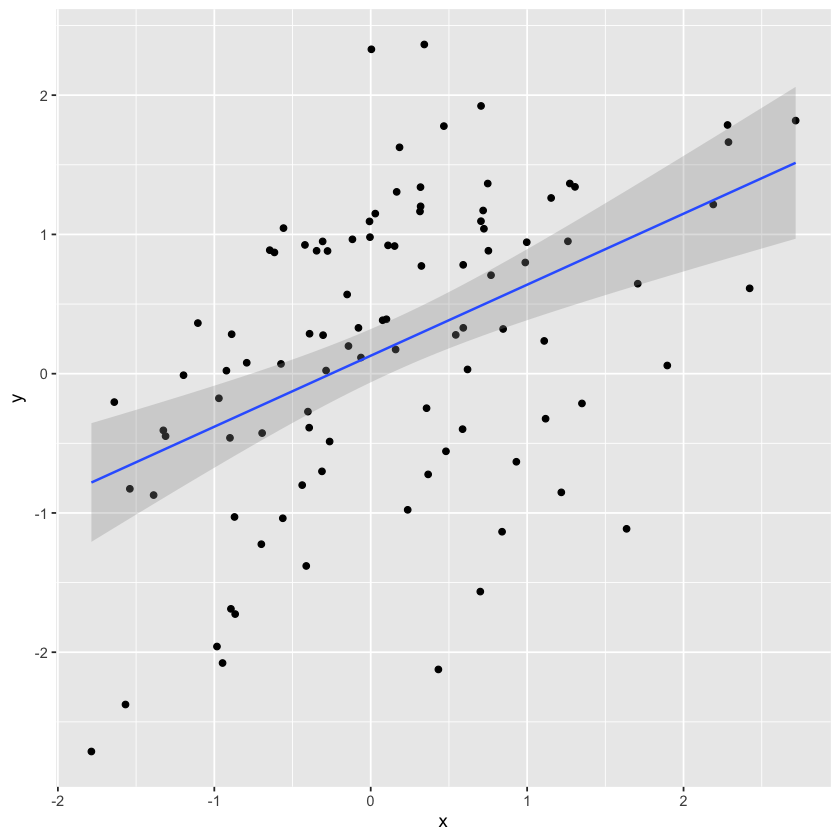

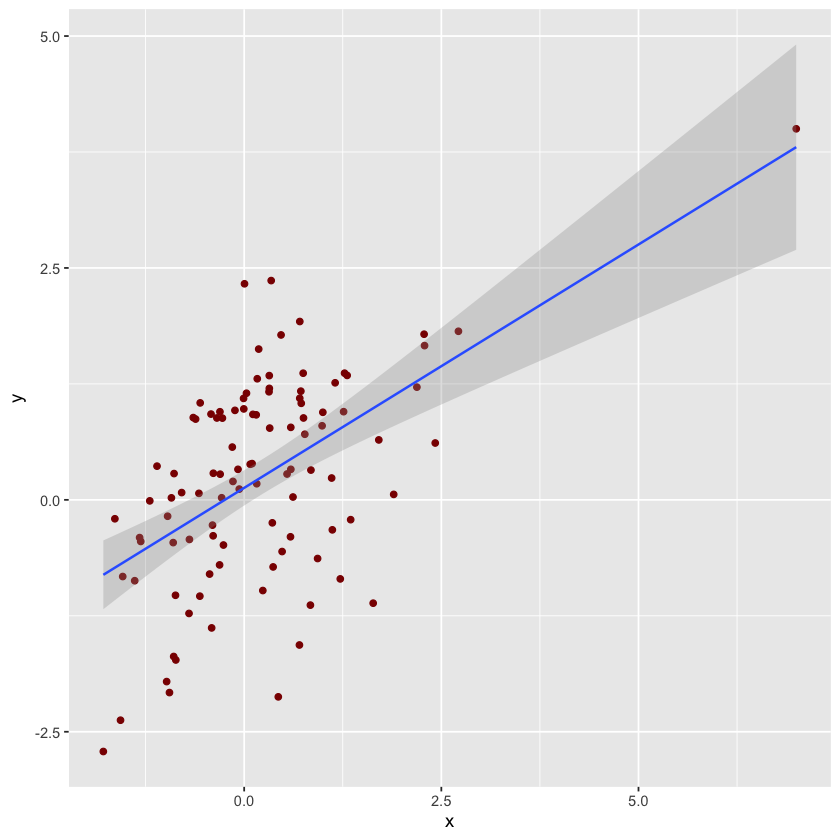

In [273]:
set.seed(7)
x <- rnorm(100,mean=0,sd=1)    #defining a random predictor
ex <- rnorm(100,mean=0,sd=1)   #some unexplained error
y <- 0.5*x + ex             
sim_df <- data.frame(x, y)

#without outlier
summary(lm(y~x, data = sim_df))
gf_point(y ~ x, data = sim_df) %>% gf_lm(interval = "confidence")

#with an outlier added
sim_df_outlier <- add_row(sim_df, x=7, y=4)
summary(lm(y~x, data = sim_df_outlier))
gf_point(y ~ x, data = sim_df_outlier, color='darkred') %>% gf_lm(interval = "confidence")

In the plot with red dots, the outlier at x=7 is far outside the other x values. But notice that the $b_1$ estimate in this case (0.52) is not that much different than the initial estimate without an outlier (0.51). 

Now consider this plot:

In [ ]:
#another outlier
sim_df_outlier <- add_row(sim_df, x=7, y=-2)
summary(lm(y~x, data = sim_df_outlier))
gf_point(y ~ x, data = sim_df_outlier, color='darkgreen') %>% gf_lm(interval = "confidence")

We have another example with an outlier that is extreme on x, but this time the $b_1$ estimate is 0.23. That's less than half the size of the correlation estimate without this outlier. What happened?

The answer is something called **leverage**. An outlier has leverage if its presence meaningfully changes the effect estimate in a sample. This would happen if the relationship between the x and y values for that data point are very different than expected; i.e. it has a huge residual. You can see this in the green plot above, where the outlier is far below the regression line. Since the regression line is trying to balance the amount of error above and below, a huge residual for one data point means the line is going to tip towards that outlier to compensate. This is why the outlier in the red plot didn't have much leverage - its values were extreme on x and y, but it still fell close to the initial regression line so it didn't change the slope estimate by much.

Here is a simulation of the effect of adding one outlier to a sample of data:

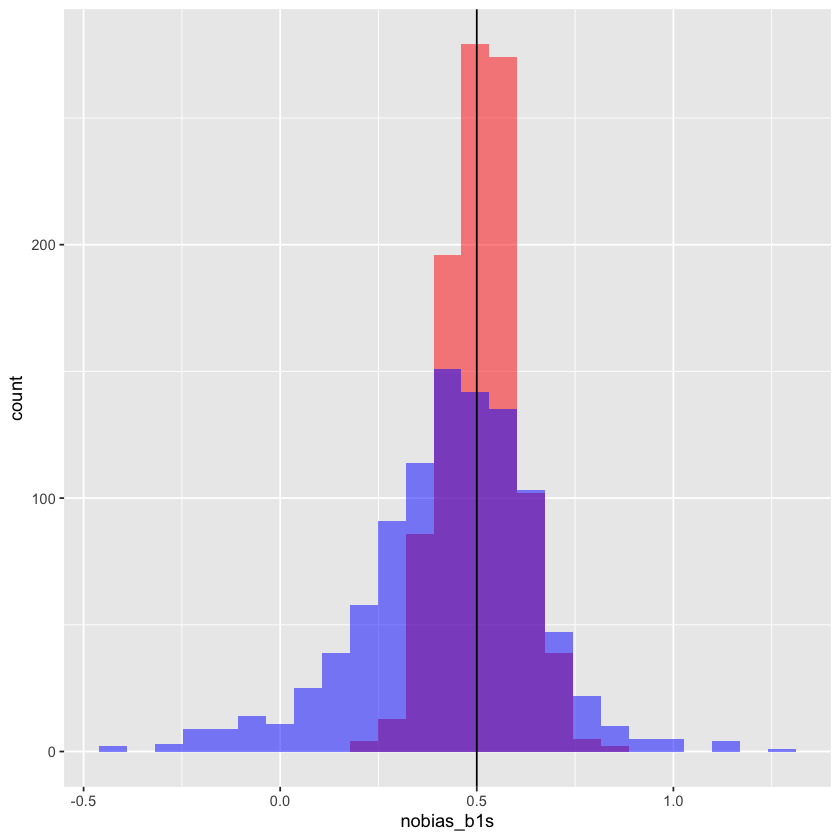

In [274]:
nobias_b1s <- vector(length=1000)
bias_b1s <- vector(length=1000)

for (i in 1:1000) {
    sim_sample <- slice_sample(sim_df, n=100, replace=TRUE) 
    sim_model <- lm(y ~ x, data = sim_sample)  #fitting model in data without outlier
    nobias_b1s[i] <- sim_model$coefficients[[2]]
    
    outlier_sample <- add_row(sim_sample, x=rnorm(1,0,5), y=rnorm(1,0,5)) #adding an outlier
    sim_model <- lm(y ~ x, data = outlier_sample) #fitting model in data with outlier
    bias_b1s[i] <- sim_model$coefficients[[2]]
}

#red = unbiased sampling distribution
#blue = biased sampling distribution
gf_histogram(~ nobias_b1s, fill="red", alpha=0.5) %>% 
    gf_histogram(~ bias_b1s, fill="blue", alpha=0.5) %>%
    gf_vline(., xintercept = 0.5) #true b1 is 0.5

There's a bit of bias to this blue distribution (it's not perfectly normal), because more often "noise" like an outlier added to a variable will make statistical associations weaker instead of stronger. The biased sampling distribution is also wider, so we have a problem with the standard error estimate again. In situations with leverage, our $b_1$ estimates are likely to be biased downwards *and* our p-values will be wrong. 

### 4) Non-normal residuals

A related situation is when there isn't one particular data point with a lot of leverage, but the overall error distribution is highly skewed. Here's an example of what non-normal residuals might look like:  

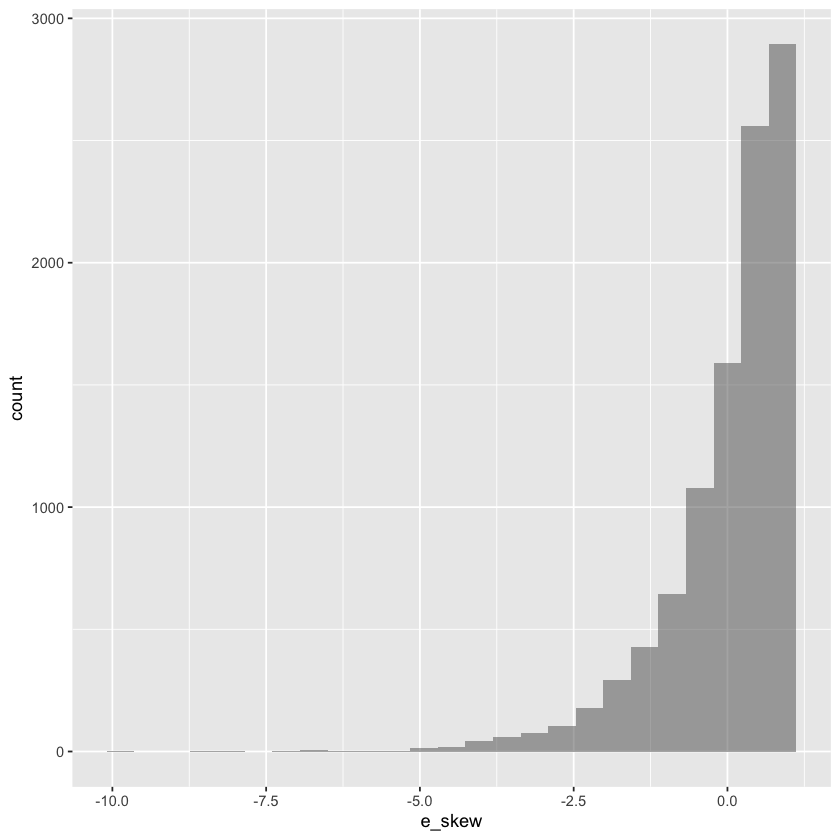

In [275]:
x <- runif(10000,0,5)           #defining a random variable
e_norm <- runif(10000,0,1)
e_skew <- log(runif(10000,0,1)) #error is skewed, not normal
e_skew <- e_skew - mean(e_skew) #mean centering the error term
gf_histogram(~ e_skew)

This distribution means most of our residuals are small, but the ones that aren't are all in the same direction.

Now we simulate what such an error distribution does to our model estimations:

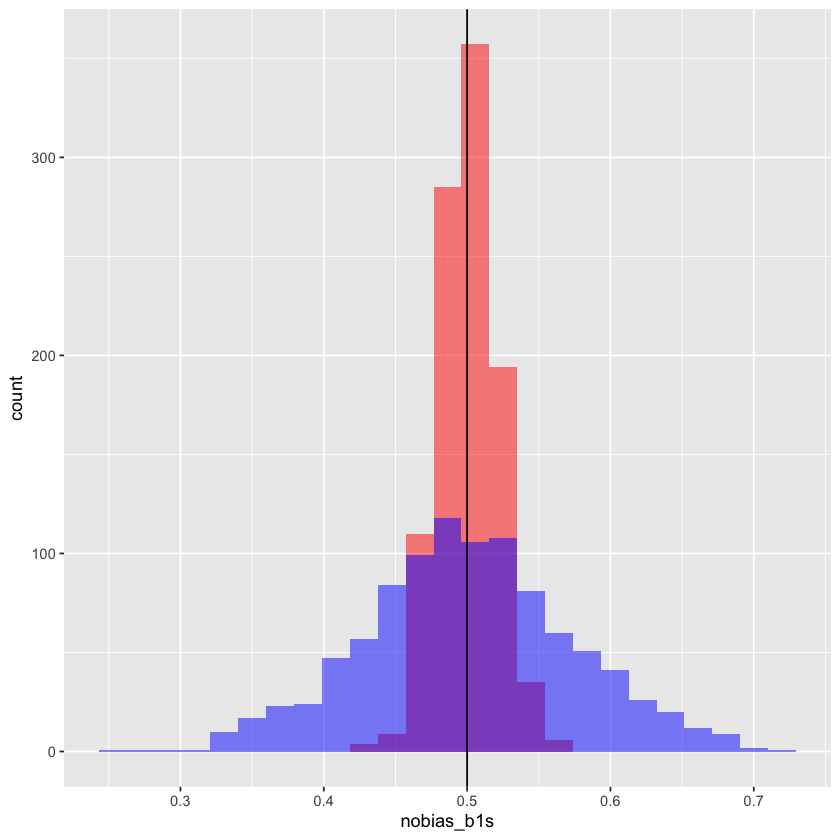

In [276]:
y_norm <- 0.5*x + e_norm
y_skew <- 0.5*x + e_skew
sim_df <- data.frame(x, y_skew, y_norm)

nobias_b1s <- vector(length=1000)
bias_b1s <- vector(length=1000)

for (i in 1:1000) {
  sim_sample <- sample_n(sim_df, size=100, replace=TRUE) 
  sim_model <- lm(y_norm ~ x, data = sim_sample) #with normal errors
  nobias_b1s[i] <- sim_model$coefficients[[2]]

  sim_model <- lm(y_skew ~ x, data = sim_sample)  #with skewed errors
  bias_b1s[i] <- sim_model$coefficients[[2]]
}

#red = unbiased sampling distribution
#blue = biased sampling distribution
gf_histogram(~ nobias_b1s, fill="red", alpha=0.5) %>% 
    gf_histogram(~ bias_b1s, fill="blue", alpha=0.5) %>%
    gf_vline(., xintercept = 0.5) #true b1 is 0.5

In this case, the sampling distribution is not really biased but the standard error will be wrong. Our p-values will be off if we don't stop to consider and fix this situation.

Note that this assumption is about the normality of the distribution of *residuals* in a model, not the distribution of the *raw variables*. That is a common misconception. A highly non-normal predictor or outcome can still produce normally-distributed errors in the model in many situations. To assess this assumption you need to check the error distribution specifically.

### 5) Multicollinearity

If you have more than one predictor in a model, they can cause problems for model estimates if they are highly related. As we learned in chapter 13, if both x1 and x2 are possible explanatory variables of y, you should include them both in a general linear model. However, it can be problematic to make conclusions about the model estimates if the predictors are highly correlated with each other. If the variation in y explained by the predictors is almost entirely overlapping, that means there is almost no unique variation attributable to either one. In that case, minute differences in the values of each variable can result in huge swings and instability in the model estimates from sample to sample. This situation is called **multicollinearity**.

Here's an example of what multicollinearity can do to model estimates. We'll first generate predictor variables that are closely related to eachother:

In [277]:
x1 <- runif(10000,0,5)    #defining a random variable
ex <- rnorm(10000,0,0.5)  #small amount of unexplained error between predictors
x2 <- x1 + ex             #another, highly related predictor variable
ey <- rnorm(10000,0,1)    #some unexplained error in the model
y <- 0.5*x1 + ey          #true data generation process only involves x1
sim_df <- data.frame(x1, x2, y)

In this data generation process, the true effect of x1 should be 0.5 and x2 is not a part of it. If we repeatedly sample and estimate the effect of x1 in a multivariable model when there is multicollinearity:

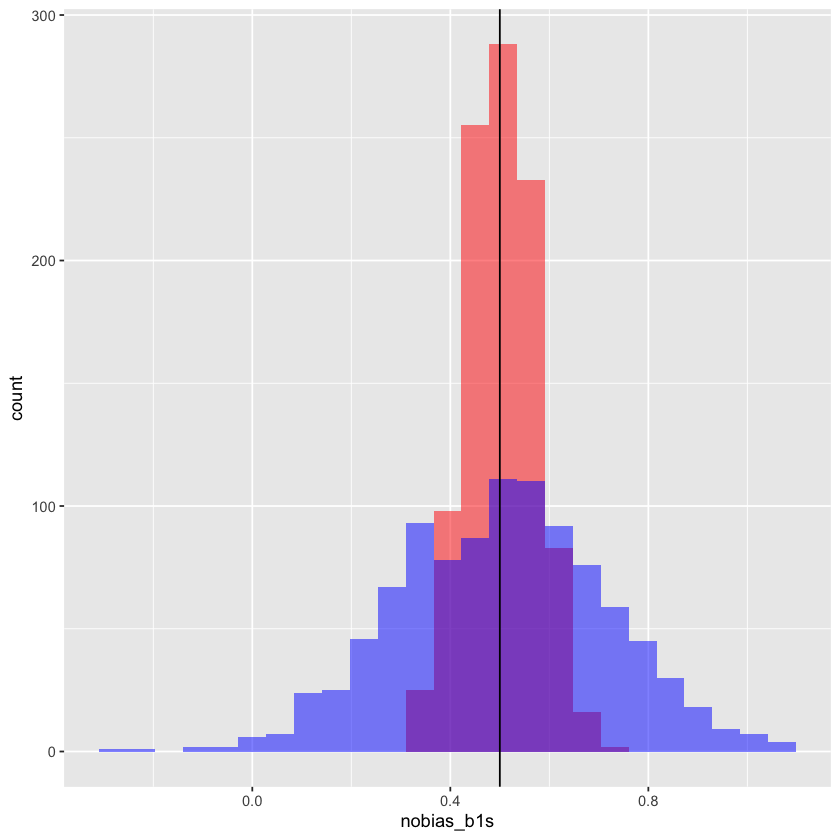

In [278]:
nobias_b1s <- vector(length=1000)
bias_b1s <- vector(length=1000)

for (i in 1:1000) {
  sim_sample <- sample_n(sim_df, size=100, replace=TRUE) 
  sim_model <- lm(y ~ x1, data = sim_sample) #unbiased estimate of x1
  nobias_b1s[i] <- sim_model$coefficients[[2]]

  sim_model <- lm(y ~ x1 + x2, data = sim_sample) #adding very multicollinear x2
  bias_b1s[i] <- sim_model$coefficients[[2]]
}

#red = unbiased sampling distribution
#blue = biased sampling distribution
gf_histogram(~ nobias_b1s, fill="red", alpha=0.5) %>% 
    gf_histogram(~ bias_b1s, fill="blue", alpha=0.5) %>%
    gf_vline(., xintercept = 0.5) #true b1 is 0.5

We don't get much bias for the $b_1$ estimate, but the standard error is wrong (width of sampling distribution). This has an unfortunate effect on the p-values of *both* x1 and x2 in the model. There's an inflated Type I error risk for x2 (the non-causal predictor) and Type II error risk for x1 (the real predictor). A model with multicollinearity is both more likely to find the wrong predictor as significant and more likely to miss which predictor is actually important. 

### 6) Repeated measures

When we collect data, sample size matters in a lot of ways. Things like p-values and error scores are calculating using degrees of freedom. This is because we assume with each new data point, we have more information about the population. Another way of saying this is that we assume data points are *independent* of each other. If you know the data value for one observation, you're not able to predict what the next data point will be. 

However, data points might not always be independent. Consider a situation where you are interested in a new test anxiety intervention, so you give some students the intervention and others you leave alone as a control group. Throughout the semester, you measure the students' quiz scores (on 5 separate quizzes) so that you have 5*N observations in your dataset - one score per quiz, per student. You want to see if there's a difference between the group averages. 

If every student took five quizzes during the semester, do you think those five quiz scores are independent of each other? If you knew student A's score on quiz 1, would it be easier to guess their score on quiz 2 than for an entirely different student? 

This is an example of what is called **repeated measures**. We took measurements from the same source (one person), and those measurements are probably not the same. But they are likely similar, such that there is more similarity between scores from the same person than there is between scores of different people. We are repeatedly measuring information from the same source, so we don't have completely new information each time. Who these scores come from affects the scores. 

<img src="images/ch19-repeatedmeasures.png" width="800">

If you run a GLM analysis on these data, you are implicitly assuming that there is more information (and more degrees of freedom) in your dataset than is actually available. This will bias standard error estimates, as you think your sample size is bigger than it effectively is. For example, here is a simulation showing the variety of b estimates that could be derived from a sample of 50 unique people, vs. 10 people assessed 5 times each. 

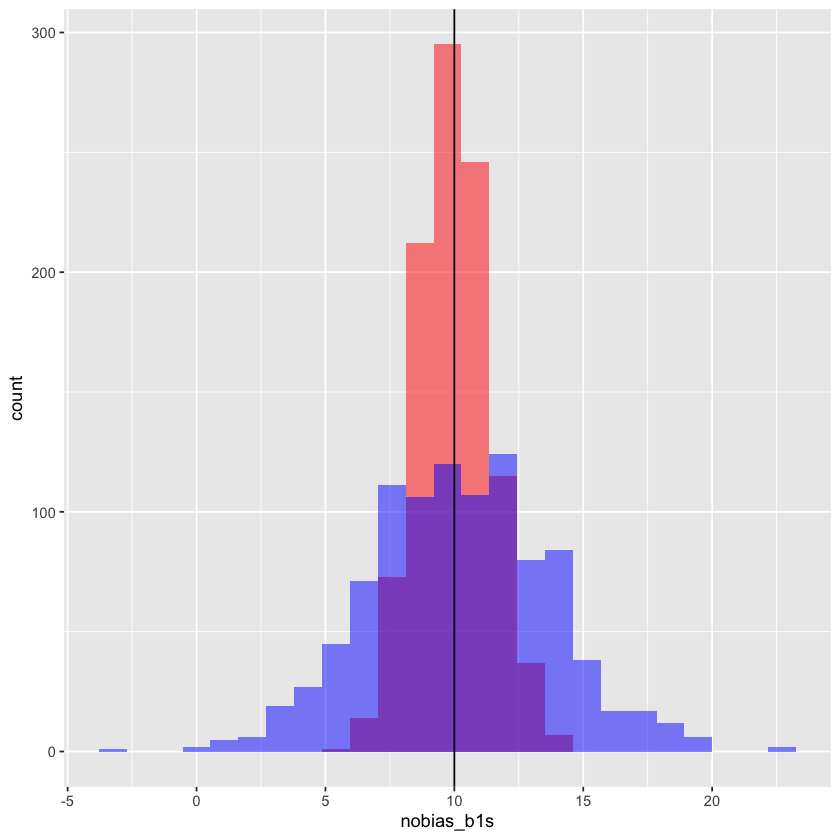

In [279]:
nobias_b1s <- vector(length=1000)
bias_b1s <- vector(length=1000)

for (i in 1:1000) {
  x <- c(rep(0,25), rep(1,25))
  e <- rnorm(50,0,5) 
  y <- 70 + 10*x + e #generating independent data
  sim_model <- lm(y ~ x) 
  nobias_b1s[i] <- sim_model$coefficients[[2]]

  r <- rnorm(10,70,5) #10 random personal mean scores
  r <- rep(r, each = 5)
  e <- rnorm(50,0,5) 
  y <- r + 10*x + e #everyone has a personalized intercept due to their personal mean
  sim_model <- lm(y ~ x) 
  bias_b1s[i] <- sim_model$coefficients[[2]]
}

#red = unbiased sampling distribution
#blue = biased sampling distribution
gf_histogram(~ nobias_b1s, fill="red", alpha=0.5) %>% 
    gf_histogram(~ bias_b1s, fill="blue", alpha=0.5) %>%
    gf_vline(., xintercept = 10) #true b1 is 10

In this simulation of biased b1 estimates, quiz scores were calculated as a function of the **fixed effect** of intervention (x), but also a function of a **random effect** of who the score came from (r). Because this makes scores correlated within a person, this reduces the amount of unique information each data point adds to a model estimation. 

### 7) Categorical outcome variable

We've talked about the problem with dichotomizing a variable before modeling - it introduces more error. The same is true if we go the other way, and try to turn a truly categorical variable into something continuous. Consider an example where you are predicting whether a new drug treatment will impact cancer prognosis. With the form of the GLM that we have learned in this course, we could predict something quantitative like white blood cell count. But if the outcome variable has instead been recorded as "Recovered" or "Not Recovered", this is categorical information. There's no "increase in Y for every 1 unit of X" we can predict in this case because there aren't quantitative values to this variable.

If we tried to do this anyways and make predictions of Y as continuous values, the vast majority of our predictions would be values that Y can never take on.

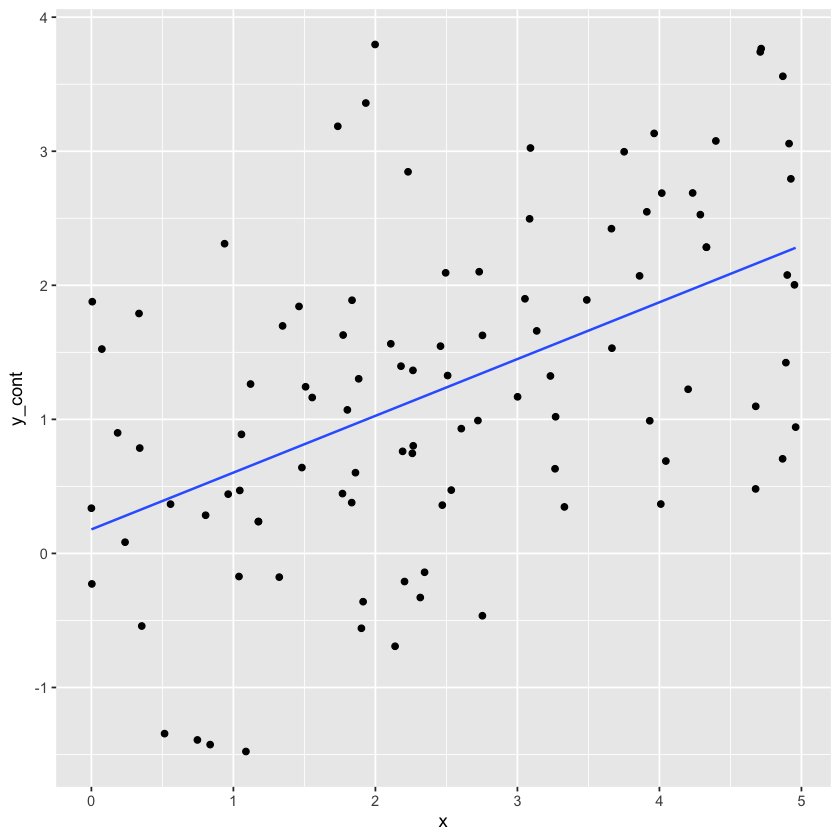

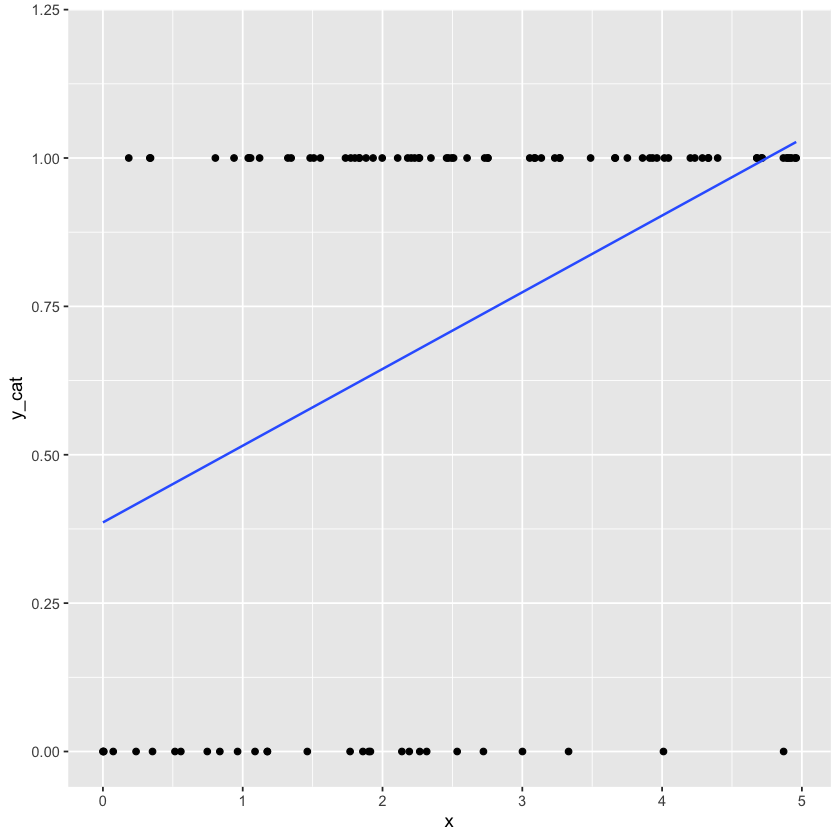

In [280]:
x <- runif(10000,0,5)       #defining a random variable
e <- rnorm(10000,0,1)       #some unexplained error in the model
y_cont <- 0.5*x + e         #a true data generation process where y is continuous
pr <- 1/(1+exp(-y_cont))    #an inverse logit transformation
y_cat <- rbinom(10000,1,pr) #to make a categorical y 
sim_df <- data.frame(x, y_cont, y_cat)

set.seed(10)
sim_sample <- sample_n(sim_df, size=100, replace=TRUE)

#linear relationship between x and a continuous y
gf_point(y_cont ~ x, data=sim_sample) %>% gf_lm()

#linear relationship between x and a categorical y
gf_point(y_cat ~ x, data=sim_sample) %>% gf_lm()

The below simulation shows the impact on the sampling distribution of b for doing this when Y is categorical (dummy-coded as 0 or 1 to make the GLM run).

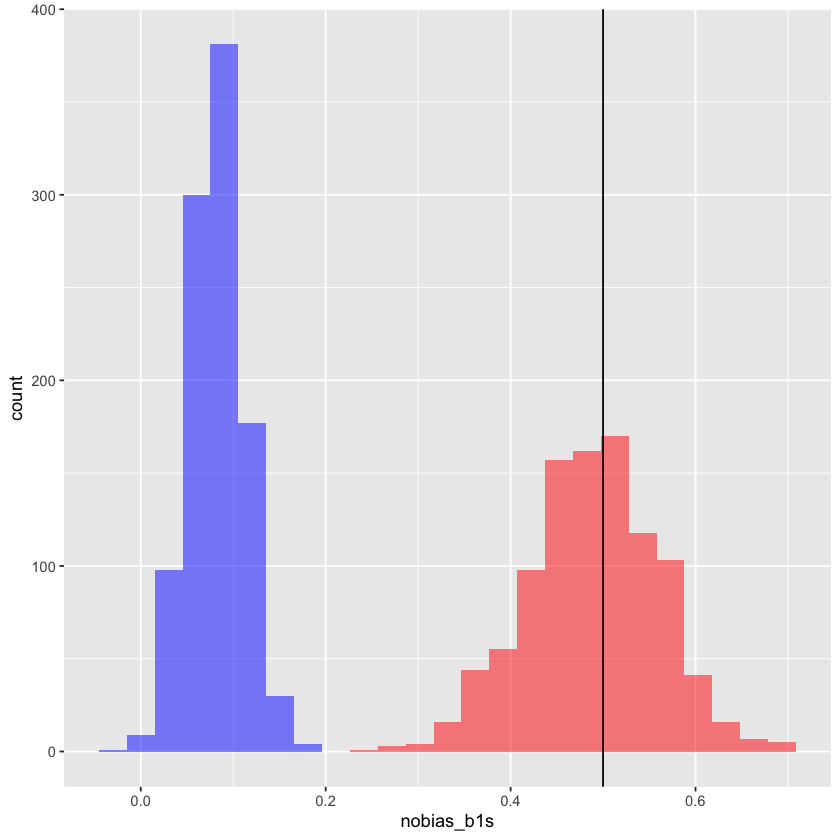

In [281]:
nobias_b1s <- vector(length=1000)
bias_b1s <- vector(length=1000)

for (i in 1:1000) {
  sim_sample <- sample_n(sim_df, size=100, replace=TRUE) 
  sim_model <- lm(y_cont ~ x, data = sim_sample) #modeling continuous y
  nobias_b1s[i] <- sim_model$coefficients[[2]]
  
  sim_model <- lm(y_cat ~ x, data = sim_sample) #modeling categorical y
  bias_b1s[i] <- sim_model$coefficients[[2]]
}

#red = unbiased sampling distribution
#blue = biased sampling distribution
gf_histogram(~ nobias_b1s, fill="red", alpha=0.5) %>% 
    gf_histogram(~ bias_b1s, fill="blue", alpha=0.5) %>%
    gf_vline(., xintercept = 0.5) #true b1 is 0.5

## 19.4 Checking for sources of bias 

The sources of bias we've discussed so far (nonlinearity, heteroscedasticity, leverage, nonnormal residuals, multicollinearity, repeated measures, and categorical outcome variables) are problems with the error distribution that comes out of a model. Thus, by plotting and examining the error distribution in certain ways, we can investigate if bias is a problem for us to consider or if we can trust our general linear modeling procedure. 

The ```performance``` package has a really easy method of checking these biases all at once, in the ```check_model()``` function. For example, let's check how a multiple regression model example from the GSS dataset performs on these assumption checks.

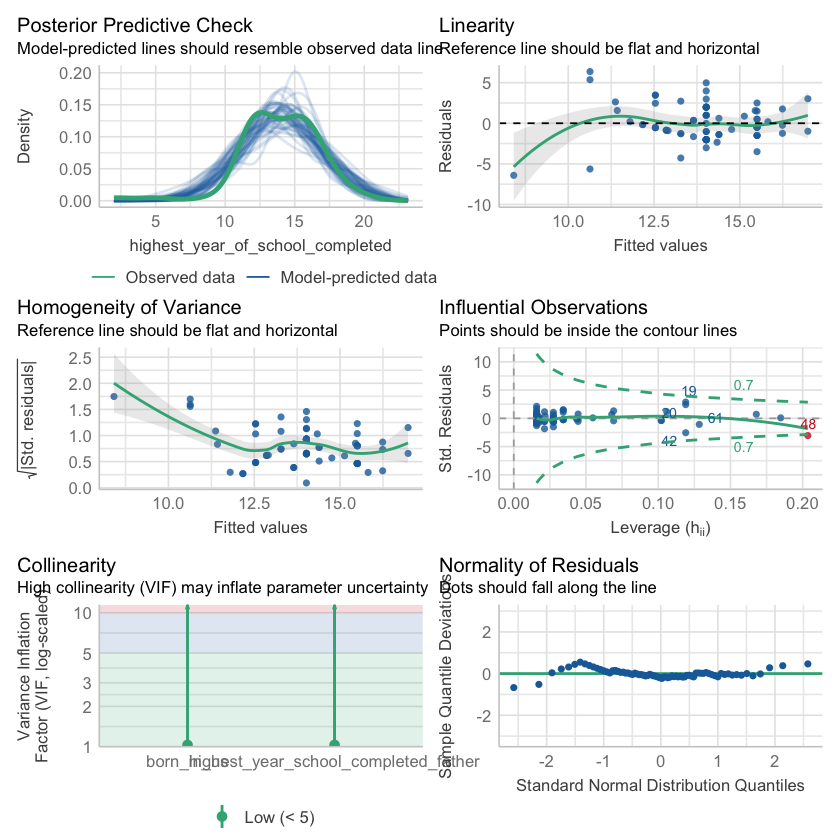

In [261]:
GSS <- read.csv("https://raw.githubusercontent.com/smburns47/Psyc158/main/GSS.csv")
set.seed(10)
GSS_subset <- slice_sample(GSS, n=100) %>% 
    select(., highest_year_of_school_completed, born_in_us, highest_year_school_completed_father) %>%
    na.omit(.)

m <- lm(highest_year_of_school_completed ~ highest_year_school_completed_father + born_in_us, 
        data = GSS_subset)
check_model(m)

Walking through these panels one by one, let's first consider the top left. This shows a bunch of predicted outcome variable distributions (blue lines) our model form would make in a simulated resampling procedure. The thick green line is a smoothed version of the actual data distribution. While this panel doesn't check any model assumptions directly, it can let you see if the predicted distributions of the outcome variable generally resemble the actual distribution. In this example, it looks like our predicted distributions on average aren't too far off. But there could be subtle assumption violations still, so let's move on to the next panel.

The top right panel checks the linearity assumption. If the relationship between predictors and outcome is linear, then residuals should be randomly distributed at all values of predictions. However if the relationship is nonlinear, a linear model will systematically underpredict some data points at one end of the outcome range and overpredict some data points at the other end of the outcome range. Thus in this scatterplot between a predicted outcome value and accompanying residual, you want the best fitting line to be approximately flat. If it's not, then that indicates the linearity assumption is violated. In this example, it looks like the best-fitting line is mostly flat, except for one point at the left side of the plot. 

Moving to the middle left plot, this investigates homogeneity of variance. This plots the variance of the residuals this time, as a function of predicted values. Remember that this assumption says there is constant variance at all levels of the variable - thus, we want this plot to have a mostly flat horizontal line. If it's notably lifted on either side, we have a situation of heteroscedasticity. In this example plot, looks again like there's one data point that's driving some heteroscedasticity on the left side of the plot. 

The middle right plot investigates leverage. This plots amount of outlierness h (expressed as metric called [Cook's Distance](https://en.wikipedia.org/wiki/Cook%27s_distance)) against the size of that data point's residual. The more a datapoint is an outlier, the smaller its residual needs to be to have high leverage on the model estimate. For this reason there is a cone in the plot to designate zones of leverage. Inside the cone are data points with low leverage, outside the cone are data points with high leverage. If a point has high leverage, it will also be colored red in this plot. In this way, we can see there is a datapoint that has been identified as high leverage - observation 48 in the dataset on which the model was fit. This data point is also probably the reason for the non-flat lines in the linearity and homogeneity of variance plots.

The bottom left panel assesses multicollinearity using a metric called [Variance Inflation Factor (VIF)](https://en.wikipedia.org/wiki/Variance_inflation_factor). We want a low VIF, meaning that the predictors in the model aren't highly related to each other and thus there is low multicollinearity. This plot defines a cutoff VIF of 5 as being the point at which parameter estimates become uncertain to a problematic degree. The VIF for each of the predictors in our example is far below the cutoff, so we don't violate the assumption of multicollinearity in this example. 

Finally, the bottom right panel assesses normality of residuals. This assesses the proportion of the error distribution that should fall in each quantile (if it follows a standard normal distribution), vs. the proportion of the error distribution that is actually in each quantile in this sample. Dots should fall mostly along the flat line at 0. If many of these dots vear far off the 0 line, the assumption of normal residuals is violated. 

The key to interpreting this plot is to know that assumption violation is a spectrum, not a yes/no quality. While we can come up with some har cutoffs (like VIF = 5 or the leverage zone), some datasets will violate assumptions much more strongly than others. Thus you need to use your judgment to decide if a little bit of violation, and thus a little bit of bias, is ok or not. 

That's five of the biases sources we've talked about, but this figure doesn't help us check for repeated measures or categorical outcome variables. That's easy enough for us to do ourselves, though. To detect repeated measures, we should consider whether there is any shared source that multiple data points in a study are coming from - the same person, same dyad of people, same school, etc. To detect categorical outcome variables, we should make sure the outcome we're modeling has many unique and numeric values. 

## 19.5 What to do about model bias

If the ```check_model()``` plot looks good, then you are good to use the GLM to test your hypotheses about your data. However, if any of these sources of bias are clearly evident, you shouldn't trust the effect estimates or statistical significance given by the GLM. Instead, depending on which of these problems are present, there are some alternative approaches you can use. These are advanced approaches beyond the scope of this intro class, but below are common options that you can read more about if you'd like:

- Non-linear modeling: if nonlinearity is present, this implies that a straight line is not the best relationship between a predictor and outcome. Other forms may better describe this relationship that you can capture by transforming a predictor variable (e.g., by log transforming X or making it into a quadratic term). Alternatively you can use tools that make more general assumptions, such as "when X goes up some amount Y goes up some amount" (i.e. [Spearman Rank Correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)) or "uncertainty in Y is reduced by knowing X" (i.e. [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information)). 

- Dimensionality reduction: The simplest way to deal with multicollinearity is to remove less important variables from your model, as this may be happening because one variable is essentially the same construct as another. However if it's not clear what variable should be removed, there are more advanced tools that search for the amount of shared variation between the multicollinear predictors and make new variable(s) just out of that. Such tools include [factor analysis](https://towardsdatascience.com/exploratory-factor-analysis-in-r-e31b0015f224), [principle component analysis](https://www.r-bloggers.com/2021/05/principal-component-analysis-pca-in-r/), and [ridge regression](https://www.statology.org/ridge-regression-in-r/).

- Robust estimation: The simplest way to deal with leverage, non-normal residuals, and heteroscedasticity is to remove specific outliers that are the reason for the problem. But if the problem isn't due to specific outliers that you can find, or if your power is so low that removing data points is a problem, there are other modeling options such as [robust regression](https://stats.oarc.ucla.edu/r/dae/robust-regression/), which weights the contribution of data points to the model fit by their leverage. This means that high leverage points or non-normal residuals have less influence on the final parameter estimates. This preserves more degrees of freedom and thus statistical power than simply removing a bunch of data points.

- Repeated measures analysis: The simplest way to deal with repeated measures is to calculate an average score within each source of data (e.g., an average quiz grade per person). However, this can greatly reduce the number of datapoints in a dataset and may throw away important *within-person* variation that a fixed effect explains. This, there are different statistical tools that don't assume independent data. These include the [paired samples t-test](https://www.r-bloggers.com/2021/10/paired-sample-t-test-using-r/) when there is a pre and post score per person; [repeated measures ANOVA](https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/) when doing a within-subjects design where subjects are exposed to multiple conditions; or [mixed-effects modeling](https://m-clark.github.io/mixed-models-with-R/random_intercepts.html) as a more generalized approach to dealing with repeated measures. 

- Non-numeric outcome modeling: Since the GLM makes numeric predictions, one should use other modeling procedures that make different types of predictions. For binary categorical data, use [logistic regression](https://stats.oarc.ucla.edu/r/dae/logit-regression/). For more categories or ordinal outcome data, use [ordinal regression](https://stats.oarc.ucla.edu/r/dae/ordinal-logistic-regression/).

## 19.6 Sources of bias from research design

The seven biases above have to do with the way a model form fits a set of data. If these biases are present, you want to change your approach to modeling. Luckily, you can assess this with the performance checks we learned and make that pivot at the analysis step.  

However there are other sources of bias that occur because of the way data was collected. This is harder to detect post-hoc and might not be able to be fixed after data collection. For this reason, you should consider these sources when you are first designing a study and recruiting subjects so that you don't create serious limitations in your research. 

### Non-representative samples
We've discussed before what it means to have a representative sample - the distribution of data in the sample closely resembles the distribution of data in the population. When your data sample is representative, the statistical estimates you make in that sample have the best chance of resembling the true population parameter. A difference between your estimate and the population parameter can happen just by bad luck during random sampling: we just happen to draw a particularly strange sample by chance. But over many samples, random sampling will insure that on the whole our samples are representative and our estimates unbiased. 

If there's any reason our sampling process is not representative, those estimates might be biased even across many samples. For example, there is a famous saying that "money does not buy happiness". If you were to test this statistically, you might look for a significant relationship between how much money people make and their happiness levels. But if you were to conduct this research only with college graduates (who make on average 80% higher salaries than non-grads), you would only be investigating the relationship between money and happiness in people with more money, not across all income brackets. No matter what sample you drew, if it was not representative of the wider population, you might get a biased estimate (and you might miss the fact that [money is indeed correlated with happiness](http://content.time.com/time/magazine/article/0,9171,2019628,00.html) at lower income levels where financial security is threatened). If your estimate is biased due to nonrepresentative sampling, it might apply to this specific subset of the population, but not **generalize to other populations of people. 

One way a sample can be unrepresentative is if you don't have values from the full range of population values on your outcome. When your data is missing the full range of the outcome variable, there's less variation present that would be explained by the predictor. Noise now has a bigger proportional presence, and the predictor can't reliably explain noise, so it estimates a weaker effect. 

<img src="images/ch20-selectiony.gif" width="500">

*[gif source](https://sites.google.com/view/robertostling/home/teaching)*

Interestingly, the same is not true for truncating the x variable. On average, the sampling distribution will still cluster around the true effect for x. The difference here is that the estimate is more variable, which affects standard errors. 

<img src="images/ch20-selectionx.gif" width="500">

*[gif source](https://sites.google.com/view/robertostling/home/teaching)*

A nonrepresentative sample doesn't *guarantee* that your estimates will be biased. Estimates will only be biased if your sample is non-representative on variables that are involved in the data generation process you are investigating. If you are investigating the relationship between money and happiness but only have a sample of right-handed people, there's a pretty good argument to make that being right or left handed doesn't influence how happy money makes you. So the assumption of representativeness only applies to variables that are involved in the particular data generation process you are investigating. 

### Omitted variable bias
In doing research and building theory, we are trying to create a model that closely approximates the data generation process. This means we hope to identify the predictor variables that are important for creating the outcome variable, with the right relationships between them. If we leave out important parts of the data generation process, especially variables that confound other predictors or are involved in interactions with other predictors, this will create bias in the parameter estimates for the predictors we do have. Such bias is called **omitted variable bias**. Omitted variable bias is responsible for erroneous conclusions in psychology, such as the notion that [the marshmellow test predicts self-control ability](https://www.washingtonpost.com/science/2024/08/29/research-bias-cognitive-studies-executive-function-marshmallow-test/) or that [AI can accurately read people's emotions through their facial expressions](https://www.scientificamerican.com/article/darwin-was-wrong-your-facial-expressions-do-not-reveal-your-emotions/), or that [you can detect lies with a polygraph test](https://www.vox.com/2014/8/14/5999119/polygraphs-lie-detectors-do-they-work). In all these cases, important other variables like cultural background or basic physiological processes better explain or moderate the initial effect.

To avoid omitted variable bias, we need to think hard about what is known of the true data generation process of an outcome variable, not just one predictor we are interested in. This means staying up to date with the latest research literature on your topic of interest and plotting out conceptual models with as much detail as one can. We should then collect these other important variables in our study and incorporate them into our modeling procedure. 

## Chapter Summary

After reading this chapter, you should be able to:

- Explain the difference between error and bias
- Explain the difference between biased and unbiased estimators
- Describe the assumptions of the general linear model where violations lead to model bias
- Check for these assumptions in a dataset
- Consider other sources of bias introduced at the time of data collection

## New concepts
- **bias**: In contrast to error (when predictions or estimates don't match the true values), bias occurs when these predictions/estimates are wrong in a systematic way.
- **homoscedasticity**: When the variance in model residuals is consisent for the whole range of model prediction values. 
- **heteroscedasticity**: When the variance in model residuals varies as a function of the model predicted value. Results in unstable effect estimates in the model. 
- **leverage**: A data point has high leverage on a model estimate when it's inclusion/exclusion heavily influences what the model estimate is. 
- **multicollinearity**: A situation when two or more predictors in a model are highly related to each other, and thus not much unique variation can be explained by either. Results in unstable effect estimates for these predictors. 
- **fixed effects**: Variation in outcome data values that are explained by some predictor variable. This predictor variable functions the same way across people.
- **random effects**: Variation in outcome data values that are explained by the person the data was collected from. 
- **omitted variable bias**: When bad statistical conclusions are made because some important component of the data generation process was left out of modeling. 
- **repeated measures**: Multiple datapoints that are collected from the same "source" and thus are not wholly independent from each other. 

## New R functionality
- [performance::check_model()](https://easystats.github.io/performance/reference/check_model.html)

[Next: Chapter 20 - Alternate Approaches - Traditional Statistical Tools](https://colab.research.google.com/github/smburns47/Psyc158/blob/main/chapter-20.ipynb)